### Notebook for the cell-cell interaction research of healthy gut with liana package

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 3rd March 2023

### Import required modules

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li
import anndata as ad

### Set up working environment

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fontTools                   4.39.3
h5py                        3.8.0
importlib_resources         NA
ipykernel                   6.19.2
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.2.0
jupyter_server              1.23.6
kiwisolver                  1.4.4
liana                       0.1.7
llvmlite                    0.39.1
matplotlib                  3.7.1
matplotlib_inline           0.1.6
mizani                      0.8.1
mpl_

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [5]:
input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Healthy_reference/Healthy_reference_predicted/SCANVI_predicted_cell_types_15K_stem_cells.h5ad'
output = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Healthy_reference/Healthy_reference_predicted/SCANVI_predicted_cell_types_15K_stem_cells_output.h5ad'

In [6]:
andata = sc.read_h5ad(input)
andata.X

<375293x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 649526885 stored elements in Compressed Sparse Row format>

### Data preprocessing

In [10]:
# Drop fetal and pediatric cells
andata = andata[andata.obs['Diagnosis'] != 'fetal']
andata = andata[andata.obs['Diagnosis'] != 'Pediatric healthy']


In [11]:
andata.obs_keys

<bound method AnnData.obs_keys of View of AnnData object with n_obs × n_vars = 114382 × 40144
    obs: 'UniqueCell_ID', 'Sample_ID', 'CellType', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'Age_group', 'total_counts_ribo', 'Location', 'n_counts', 'percent_mito', 'percent_ribo', 'Cell States', 'Predicted Cell Labels'>

### Liana Run

In [14]:
# import all individual methods
import liana 
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

### Run CellChat

In [17]:
X_is_raw(andata)

True

In [18]:
andata.raw = ad.AnnData(andata.X, andata.obs, andata.var)

In [19]:
#run cellchat
cellchat(andata, groupby='Predicted Cell Labels', expr_prop=0.1, verbose=True)

Using `.raw`!
6056 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: CLC+ Mast cell, Fetal arterial EC, K cells (GIP+), M/X cells (MLN/GHRL+), Progenitor (NEUROG3+), Stromal 2 (CH25H+), Th1
0.04 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 114362 samples and 34088 features


100%|██████████| 1000/1000 [1:33:41<00:00,  5.62s/it]


In [20]:
df = andata.obs['Predicted Cell Labels'].value_counts()

In [21]:
#Write anndata object to file
andata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/CCI/liana/Adult_all_cells_post-liana_cellChat.h5ad')

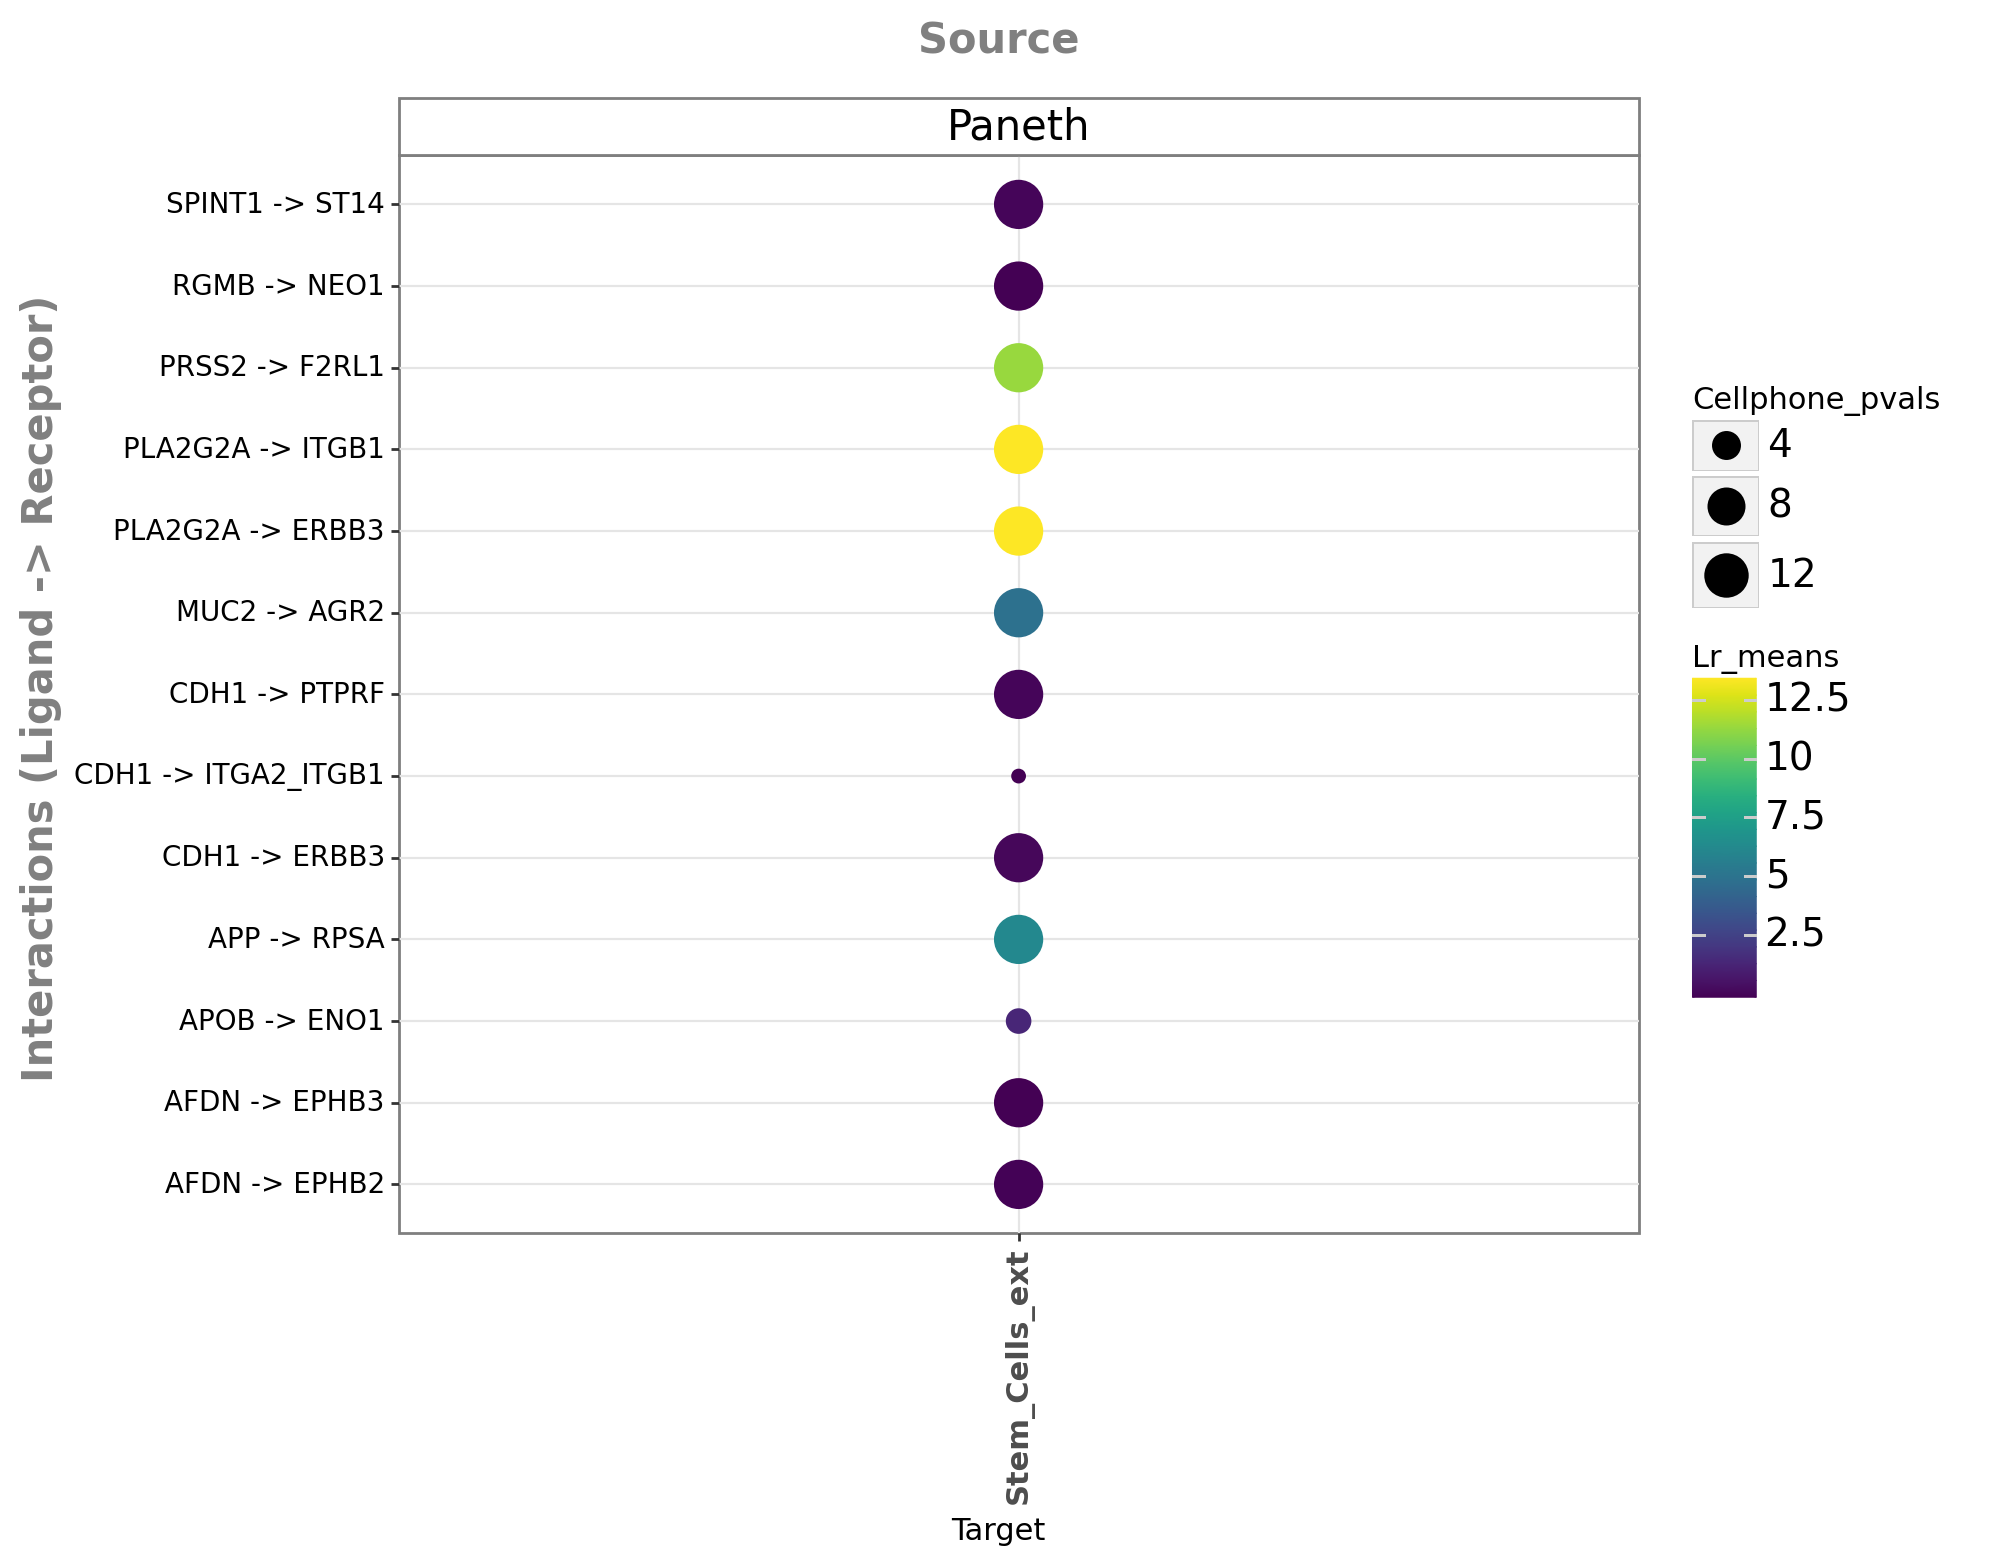

<ggplot: (1017810201)>

In [36]:
li.pl.dotplot(adata = andata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Paneth'],
              target_labels=['Stem_Cells_ext'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05
             )

In [31]:
# run cellphonedb
cellphonedb(andata, groupby='Predicted Cell Labels', expr_prop=0.1, verbose=True, use_raw=False)

Using `.X`!
4080 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.02 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 375293 samples and 36064 features


100%|██████████| 1000/1000 [39:28<00:00,  2.37s/it]


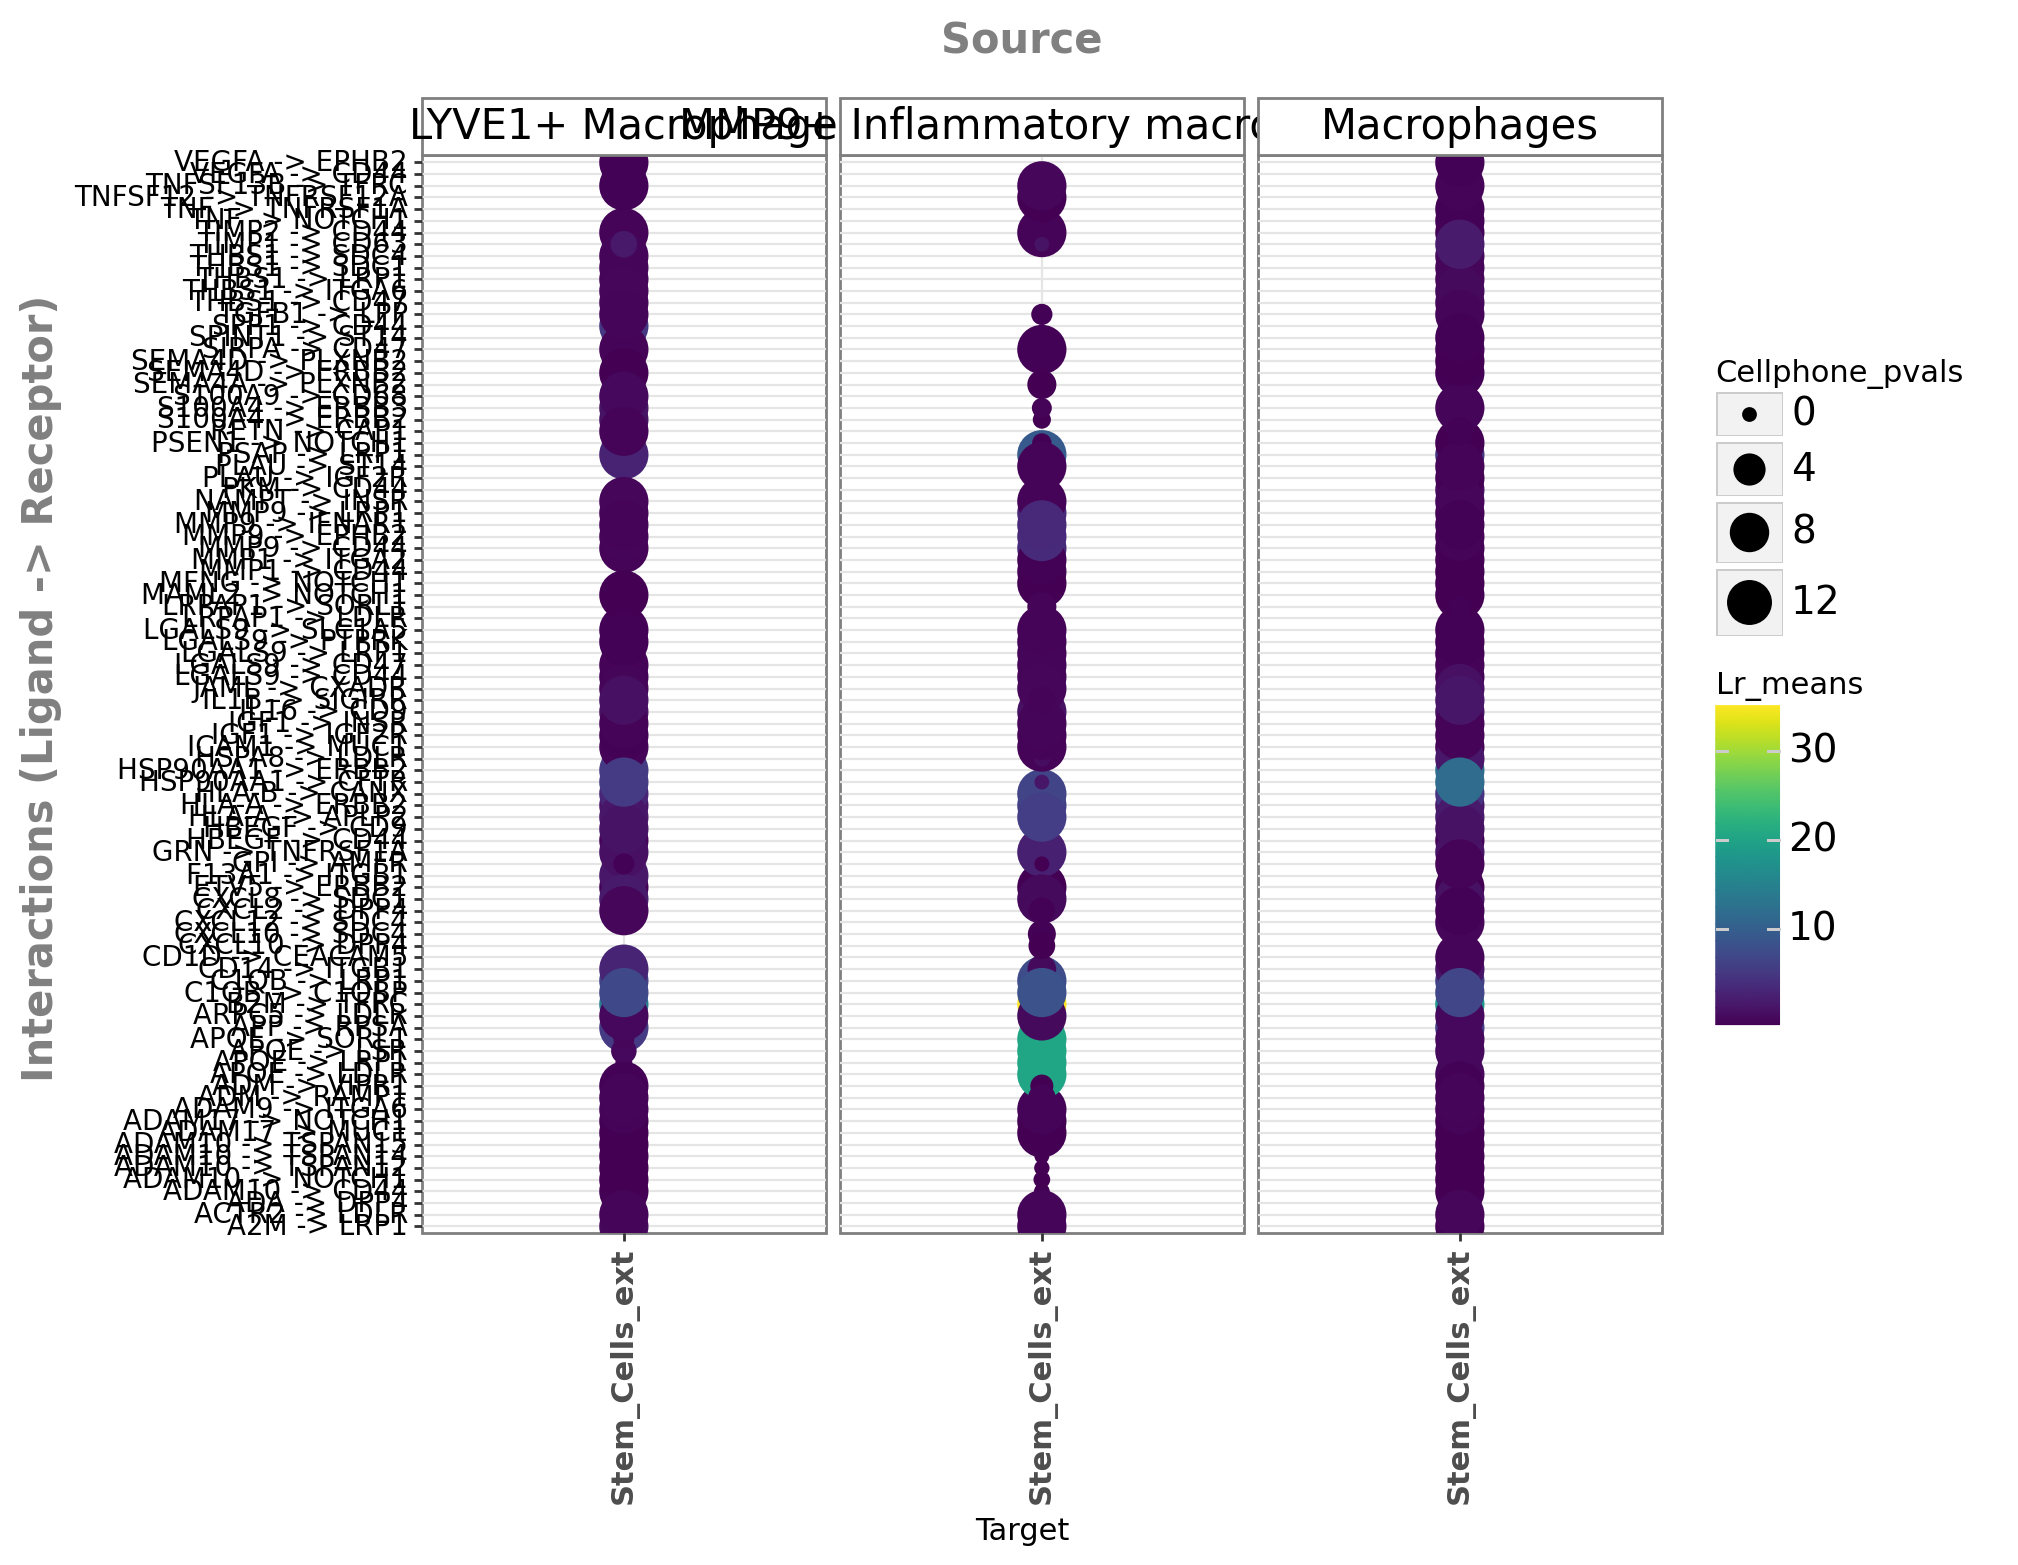

<ggplot: (1021983368)>

In [37]:
# From macropahges to stem cells
li.pl.dotplot(adata = andata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Macrophages', 'LYVE1+ Macrophage', 'MMP9+ Inflammatory macrophage'],
              target_labels=['Stem_Cells_ext'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05
             )

### Rank Aggregate

In [41]:
X_is_raw(andata)

True

In [43]:
andata.raw = ad.AnnData(andata.X, andata.obs, andata.var)

In [44]:
# Run rank_aggregate
li.mt.rank_aggregate(andata, groupby='Predicted Cell Labels', expr_prop=0.1, verbose=True)

Using `.raw`!
4080 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.02 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 375293 samples and 36064 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/liana/method/_liana_pipe.py:422: RuntimeWarning: overflow encountered in power
/Users/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/liana/method/_liana_pipe.py:415: RuntimeWarning: invalid value encountered in subtract


Running CellPhoneDB


100%|██████████| 1000/1000 [07:17<00:00,  2.29it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [4:18:29<00:00, 15.51s/it]  


In [45]:
andata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
176316,D cells (SST+),Branch A4 (IN),SST,SSTR2,1001.061659,0.0,8902.983403,27.285645,NaN,0.202200,0.998301,0.000016,0.0,NaN,NaN,3.397144e-18
1746592,D cells (SST+),Progenitor (NEUROG3+),SST,SSTR2,999.664346,0.0,3320.255649,21.353784,NaN,0.075408,0.997220,0.000005,0.0,NaN,NaN,3.484518e-15
2641578,D cells (SST+),β cells (INS+),SST,SSTR2,999.636884,0.0,3210.535309,21.237200,NaN,0.072916,0.997173,0.000008,0.0,NaN,NaN,4.179548e-15
1629890,D cells (SST+),N cells (NTS+),SST,SSTR2,999.567688,0.0,2934.072857,20.943448,NaN,0.066637,0.997044,0.000005,0.0,NaN,NaN,6.805691e-15
807367,D cells (SST+),I cells (CCK+),SST,SSTR2,999.532808,0.0,2794.715941,20.795375,NaN,0.063472,0.996971,0.000005,0.0,NaN,NaN,7.878435e-15


In [46]:
rank_aggregate.describe()

NameError: name 'rank_aggregate' is not defined

In [47]:
#Write anndata object to file
andata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/CCI/liana/All_cell_types_after_liana_aggregated.h5ad')

In [ ]:
li.pl.dotplot(adata = andata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['Paneth'],
              target_labels=['Stem_Cells_ext'],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

In [ ]:
my_plot = li.pl.dotplot(adata = andata,
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['Paneth'],
                        target_labels=['Stem_Cells_ext'],
                        filterby='specificity_rank',
                        filter_lambda=lambda x: x <= 0.01,
                       )
my_plot